In [15]:
import collections
# Prepare paths to local utilities
import os
import sys

import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [16]:
models_path = os.path.abspath(os.path.join('..', 'model'))
utils_path = os.path.abspath(os.path.join('..', 'util'))
sys.path.append(models_path)
sys.path.append(utils_path)

In [17]:

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
from download.DataDownloader import DataDownloader
from collect.DataframeCollector import DataframeCollector
from collect.TestSetSplitter import TestSetSplitter
from reservoir.BasicESN import BasicESN

In [19]:
data_path = os.path.abspath(os.path.join('..', 'data'))

In [20]:
# Download data
downloader = DataDownloader()
downloader.download_data('har70plus', data_path)

Dataset already downloaded


True

In [21]:
# Collect data into dataframes
collector = DataframeCollector()
collector.load_full_dataset(data_path + '/har70plus')

Discovered  18  csv files in  D:\Pycharm\COM6906-Dissertation\data/har70plus
Loading the csv files into dataframes
Loaded  18  dataframes
Concatenating the dataframes


,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label,record_num
0,2021-03-24 14:42:03.839,-0.999023,-0.063477,0.140625,-0.980469,-0.112061,-0.048096,6,0
1,2021-03-24 14:42:03.859,-0.980225,-0.079346,0.140625,-0.961182,-0.121582,-0.051758,6,1
2,2021-03-24 14:42:03.880,-0.950195,-0.076416,0.140625,-0.949463,-0.080566,-0.067139,6,2
3,2021-03-24 14:42:03.900,-0.954834,-0.059082,0.140381,-0.957520,-0.046143,-0.050781,6,3
4,2021-03-24 14:42:03.920,-0.972412,-0.042969,0.142822,-0.977051,-0.023682,-0.026611,6,4
...,...,...,...,...,...,...,...,...,...
2259592,2021-06-11 11:13:14.098,-0.960693,-0.199951,-0.330566,-0.977051,0.006104,-0.246826,1,2259592
2259593,2021-06-11 11:13:14.118,-0.942627,-0.210205,-0.331543,-0.969482,0.004883,-0.231445,1,2259593
2259594,2021-06-11 11:13:14.138,-0.907227,-0.190918,-0.320312,-1.048096,0.067627,-0.234375,1,2259594
2259595,2021-06-11 11:13:14.159,-0.883057,-0.156982,-0.311279,-1.007080,0.063965,-0.248047,1,2259595


In [25]:
# The collector provides one large dataframe with all the data concatenated, and also an array of dataframes, one for each subject
dataframes = collector.get_dataframes()

test_split = 0.2
train_split = 1 - test_split
validation_split = 0.2

validation_from_train = True
use_slices = False

splitter = TestSetSplitter(test_split=test_split, val_split=validation_split, val_from_train=validation_from_train, seed=1234)
train, val, test = splitter.split(dataframes, use_slices=use_slices)

Data shape:  [(103860, 9), (131367, 9), (116413, 9), (150758, 9), (87006, 9), (122714, 9), (120125, 9), (130494, 9), (121763, 9), (122061, 9), (128063, 9), (119310, 9), (123599, 9), (101510, 9), (153517, 9), (138278, 9), (147045, 9), (141714, 9)]


In [26]:
slice_size = 128
slices_in_df_1 = len(collector.get_dataframes()[0]) // slice_size

print(len(train), len(val), len(test))

17 17 18


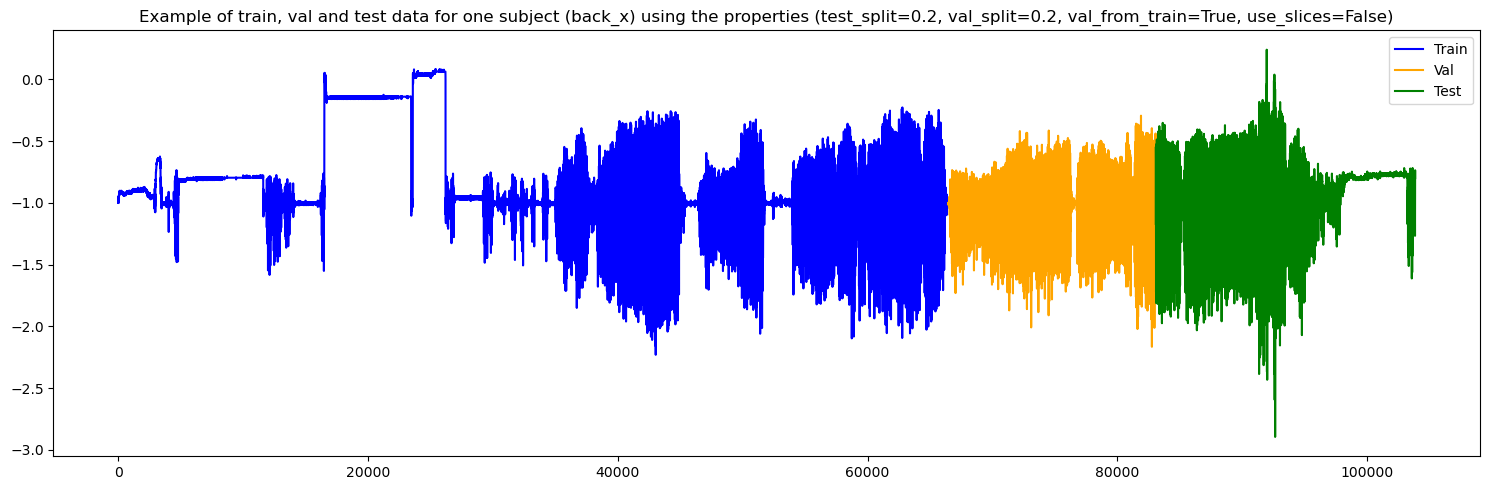

In [27]:
# Lets plot the data on a graph, colouring by whether it is train, val or test data
# Plot the column for back_x
plt.figure(figsize=(15, 5))
if (use_slices):
    train_slice = int(((slices_in_df_1 * train_split) * (1 - validation_split)) if validation_from_train else (slices_in_df_1 * (1 - test_split - validation_split)))
    for i, df in enumerate(train[:train_slice]):
        plt.plot(df['back_x'], label='Train', color='blue')
    
    val_slice = int((slices_in_df_1 * train_split) * validation_split) if validation_from_train else (slices_in_df_1 * validation_split)
    for i, df in enumerate(val[:val_slice]):
        plt.plot(df['back_x'], label='Val', color='orange')
    
    test_slice = int((slices_in_df_1 * test_split))
    for i, df in enumerate(test[:test_slice]):
        plt.plot(df['back_x'], label='Test', color='green')
        
    # Define a custom legend
    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], color='blue', lw=2),
                    Line2D([0], [0], color='orange', lw=2),
                    Line2D([0], [0], color='green', lw=2)]
    plt.legend(custom_lines, ['Train', 'Val', 'Test'])
else:
    plt.plot(train[0]['back_x'], label='Train', color='blue')
    plt.plot(val[0]['back_x'], label='Val', color='orange')
    plt.plot(test[0]['back_x'], label='Test', color='green')
    plt.legend()
    
plt.title(f'Example of train, val and test data for one subject (back_x) using the properties (test_split={test_split}, val_split={validation_split}, val_from_train={validation_from_train}, use_slices={use_slices})')
plt.tight_layout()
plt.show()

In [28]:
# To use this ESN, we need to concatenate all of the training data into one large dataframe
train_df = pd.concat(train)

In [29]:
# Check the shape of the dataframe
train_df.shape

(1357646, 9)

In [40]:
# Let's split the data into input and output, where the input is the 6 columns ['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z'] and the output is the label column 'label'
input_columns = ['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']
output_columns = ['label']

X_train = train_df[input_columns].values
y_train = train_df[output_columns].values

X_train.shape, y_train.shape

((1357646, 6), (1357646, 1))

In [41]:
# The label can be one of 7 values, so we need to one-hot encode it
from sklearn.preprocessing import OneHotEncoder

# The 7 values it can be are [1,3,4,5,6,7,8]

# Create the encoder
encoder = OneHotEncoder(categories='auto')

# Fit the encoder to the labels
encoder.fit(y_train)

# Transform the labels
y_train = encoder.transform(y_train).toarray()

# Check the shape of the one-hot encoded labels
y_train.shape


(1357646, 7)

In [42]:
# Get the first few rows of the one-hot encoded labels
y_train[:5]

array([[0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.]])

In [43]:
# Now we need to create the ESN

# We can star by defining the input weights for the data

# To do this, we will create a matrix of shape (n_neurons, n_features) where n_neurons is the number of neurons in the reservoir and n_features is the number of features in the input signal
# We will then populate this matrix from a density function where elements are 1 for a value p, and 0 for a value of 1-p
# This will give us a sparse matrix with a density of p

n_features = 6
density = 0.1
n_neurons = 600

# Generate the input weights
input_weights = np.random.rand(n_neurons, n_features) < density

# Check the shape of the input weights
print(input_weights.shape)



(600, 6)


In [44]:
# Next, we initialise the ESN
# We will use the BasicESN class from the reservoir.BasicESN module

leakage_rate = 0.3
spectral_radius = 0.9
gamma = 1.0
W_in = input_weights

esn = BasicESN(leakage_rate=leakage_rate, spectral_radius=spectral_radius, gamma=gamma, n_neurons=n_neurons, W_in=W_in)

In [ ]:
# Now we need to train the ESN
# We will train the ESN using the training data

esn.fit(X_train, y_train)
